Downloaded from ...

https://www.tensorflow.org/text/tutorials/bert_glue

on ...

Thursday, January 12, 2023

KAUWITB

conda activate tf211

##### Copyright 2020 The TensorFlow Hub Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/bert_glue"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/bert_glue.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/bert_glue.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/bert_glue.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/collections/bert/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

# Solve GLUE tasks using BERT on TPU

BERT can be used to solve many problems in natural language processing. You will learn how to fine-tune BERT for many tasks from the [GLUE benchmark](https://gluebenchmark.com/):

1. [CoLA](https://nyu-mll.github.io/CoLA/) (Corpus of Linguistic Acceptability): Is the sentence grammatically correct?

1. [SST-2](https://nlp.stanford.edu/sentiment/index.html) (Stanford Sentiment Treebank): The task is to predict the sentiment of a given sentence.

1. [MRPC](https://www.microsoft.com/en-us/download/details.aspx?id=52398) (Microsoft Research Paraphrase Corpus): Determine whether a pair of sentences are semantically equivalent.

1. [QQP](https://data.quora.com/First-Quora-Dataset-Release-Question-Pairs) (Quora Question Pairs2): Determine whether a pair of questions are semantically equivalent.

1. [MNLI](http://www.nyu.edu/projects/bowman/multinli/) (Multi-Genre Natural Language Inference): Given a premise sentence and a hypothesis sentence, the task is to predict whether the premise entails the hypothesis (entailment), contradicts the hypothesis (contradiction), or neither (neutral).

1. [QNLI](https://rajpurkar.github.io/SQuAD-explorer/)(Question-answering Natural Language Inference): The task is to determine whether the context sentence contains the answer to the question.

1. [RTE](https://aclweb.org/aclwiki/Recognizing_Textual_Entailment)(Recognizing Textual Entailment): Determine if a sentence entails a given hypothesis or not.

1. [WNLI](https://cs.nyu.edu/faculty/davise/papers/WinogradSchemas/WS.html)(Winograd Natural Language Inference): The task is to predict if the sentence with the pronoun substituted is entailed by the original sentence.

This tutorial contains complete end-to-end code to train these models on a TPU. You can also run this notebook on a GPU, by changing one line (described below).

In this notebook, you will:

- Load a BERT model from TensorFlow Hub
- Choose one of GLUE tasks and download the dataset
- Preprocess the text
- Fine-tune BERT (examples are given for single-sentence and multi-sentence datasets)
- Save the trained model and use it

Key point: The model you develop will be end-to-end. The preprocessing logic will be included in the model itself, making it capable of accepting raw strings as input.

Note: This notebook should be run using a TPU. In Colab, choose **Runtime -> Change runtime type** and verify that a **TPU** is selected.


## Setup

You will use a separate model to preprocess text before using it to fine-tune BERT. This model depends on [tensorflow/text](https://github.com/tensorflow/text), which you will install below.

In [2]:
!pip install -q -U "tensorflow-text==2.8.*"

You will use the AdamW optimizer from [tensorflow/models](https://github.com/tensorflow/models) to fine-tune BERT, which you will install as well.

In [3]:
!pip install -q -U tf-models-official==2.7.0

In [4]:
!pip install -U tfds-nightly

In [5]:
import os
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tensorflow_text as text  # A dependency of the preprocessing model
import tensorflow_addons as tfa
from official.nlp import optimization
import numpy as np

tf.get_logger().setLevel('ERROR')

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


Next, configure TFHub to read checkpoints directly from TFHub's Cloud Storage buckets. This is only recommended when running TFHub models on TPU.

Without this setting TFHub would download the compressed file and extract the checkpoint locally. Attempting to load from these local files will fail with the following error:

```
InvalidArgumentError: Unimplemented: File system scheme '[local]' not implemented
```

This is because the [TPU can only read directly from Cloud Storage buckets](https://cloud.google.com/tpu/docs/troubleshooting#cannot_use_local_filesystem).

Note: This setting is automatic in Colab.

In [6]:
os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"

### Connect to the TPU worker

The following code connects to the TPU worker and changes TensorFlow's default device to the CPU device on the TPU worker. It also defines a TPU distribution strategy that you will use to distribute model training onto the 8 separate TPU cores available on this one TPU worker. See TensorFlow's [TPU guide](https://www.tensorflow.org/guide/tpu) for more information.

In [7]:
import os

if os.environ['COLAB_TPU_ADDR']:
  cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
  tf.config.experimental_connect_to_cluster(cluster_resolver)
  tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
  strategy = tf.distribute.TPUStrategy(cluster_resolver)
  print('Using TPU')
elif tf.config.list_physical_devices('GPU'):
  strategy = tf.distribute.MirroredStrategy()
  print('Using GPU')
else:
  raise ValueError('Running on CPU is not recommended.')

2022-12-15 12:12:12.050007: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Using TPU


## Loading models from TensorFlow Hub

Here you can choose which BERT model you will load from TensorFlow Hub and fine-tune.
There are multiple BERT models available to choose from.

  - [BERT-Base](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3), [Uncased](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) and [seven more models](https://tfhub.dev/google/collections/bert/1) with trained weights released by the original BERT authors.
  - [Small BERTs](https://tfhub.dev/google/collections/bert/1) have the same general architecture but fewer and/or smaller Transformer blocks, which lets you explore tradeoffs between speed, size and quality.
  - [ALBERT](https://tfhub.dev/google/collections/albert/1): four different sizes of "A Lite BERT" that reduces model size (but not computation time) by sharing parameters between layers.
  - [BERT Experts](https://tfhub.dev/google/collections/experts/bert/1): eight models that all have the BERT-base architecture but offer a choice between different pre-training domains, to align more closely with the target task.
  - [Electra](https://tfhub.dev/google/collections/electra/1) has the same architecture as BERT (in three different sizes), but gets pre-trained as a discriminator in a set-up that resembles a Generative Adversarial Network (GAN).
  - BERT with Talking-Heads Attention and Gated GELU [[base](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1), [large](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1)] has two improvements to the core of the Transformer architecture.

See the model documentation linked above for more details.

In this tutorial, you will start with BERT-base. You can use larger and more recent models for higher accuracy, or smaller models for faster training times. To change the model, you only need to switch a single line of code (shown below). All the differences are encapsulated in the SavedModel you will download from TensorFlow Hub.

In [8]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_uncased_L-24_H-1024_A-16", "bert_en_wwm_uncased_L-24_H-1024_A-16", "bert_en_cased_L-12_H-768_A-12", "bert_en_cased_L-24_H-1024_A-16", "bert_en_wwm_cased_L-24_H-1024_A-16", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "albert_en_large", "albert_en_xlarge", "albert_en_xxlarge", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base", "talking-heads_large"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/3',
    'bert_en_wwm_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_wwm_uncased_L-24_H-1024_A-16/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_en_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-24_H-1024_A-16/3',
    'bert_en_wwm_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_wwm_cased_L-24_H-1024_A-16/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'albert_en_large':
        'https://tfhub.dev/tensorflow/albert_en_large/2',
    'albert_en_xlarge':
        'https://tfhub.dev/tensorflow/albert_en_xlarge/2',
    'albert_en_xxlarge':
        'https://tfhub.dev/tensorflow/albert_en_xxlarge/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
    'talking-heads_large':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_wwm_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_wwm_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_large':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_xlarge':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_xxlarge':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_large':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print('BERT model selected           :', tfhub_handle_encoder)
print('Preprocessing model auto-selected:', tfhub_handle_preprocess)

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocessing model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## Preprocess the text

On the [Classify text with BERT colab](https://www.tensorflow.org/text/tutorials/classify_text_with_bert) the preprocessing model is used directly embedded with the BERT encoder.

This tutorial demonstrates how to do preprocessing as part of your input pipeline for training, using Dataset.map, and then merge it into the model that gets exported for inference. That way, both training and inference can work from raw text inputs, although the TPU itself requires numeric inputs.

TPU requirements aside, it can help performance have preprocessing done asynchronously in an input pipeline (you can learn more in the [tf.data performance guide](https://www.tensorflow.org/guide/data_performance)).

This tutorial also demonstrates how to build multi-input models, and how to adjust the sequence length of the inputs to BERT.

Let's demonstrate the preprocessing model.

In [9]:
bert_preprocess = hub.load(tfhub_handle_preprocess)
tok = bert_preprocess.tokenize(tf.constant(['Hello TensorFlow!']))
print(tok)

<tf.RaggedTensor [[[7592], [23435, 12314], [999]]]>


Each preprocessing model also provides a method, `.bert_pack_inputs(tensors, seq_length)`, which takes a list of tokens (like `tok` above) and a sequence length argument. This packs the inputs to create a dictionary of tensors in the format expected by the BERT model.

In [10]:
text_preprocessed = bert_preprocess.bert_pack_inputs([tok, tok], tf.constant(20))

print('Shape Word Ids : ', text_preprocessed['input_word_ids'].shape)
print('Word Ids       : ', text_preprocessed['input_word_ids'][0, :16])
print('Shape Mask     : ', text_preprocessed['input_mask'].shape)
print('Input Mask     : ', text_preprocessed['input_mask'][0, :16])
print('Shape Type Ids : ', text_preprocessed['input_type_ids'].shape)
print('Type Ids       : ', text_preprocessed['input_type_ids'][0, :16])

Shape Word Ids :  (1, 20)
Word Ids       :  tf.Tensor(
[  101  7592 23435 12314   999   102  7592 23435 12314   999   102     0
     0     0     0     0], shape=(16,), dtype=int32)
Shape Mask     :  (1, 20)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 20)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0], shape=(16,), dtype=int32)


Here are some details to pay attention to:
- `input_mask` The mask allows the model to cleanly differentiate between the content and the padding. The mask has the same shape as the `input_word_ids`, and contains a 1 anywhere the `input_word_ids` is not padding.
- `input_type_ids` has the same shape as `input_mask`, but inside the non-padded region, contains a 0 or a 1 indicating which sentence the token is a part of.

Next, you will create a preprocessing model that encapsulates all this logic. Your model will take strings as input, and return appropriately formatted objects which can be passed to BERT.

Each BERT model has a specific preprocessing model, make sure to use the proper one described on the BERT's model documentation.

Note: BERT adds a "position embedding" to the token embedding of each input, and these come from a fixed-size lookup table. That imposes a max seq length of 512 (which is also a practical limit, due to the quadratic growth of attention computation). For this Colab 128 is good enough.

In [11]:
def make_bert_preprocess_model(sentence_features, seq_length=128):
  """Returns Model mapping string features to BERT inputs.

  Args:
    sentence_features: a list with the names of string-valued features.
    seq_length: an integer that defines the sequence length of BERT inputs.

  Returns:
    A Keras Model that can be called on a list or dict of string Tensors
    (with the order or names, resp., given by sentence_features) and
    returns a dict of tensors for input to BERT.
  """

  input_segments = [
      tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
      for ft in sentence_features]

  # Tokenize the text to word pieces.
  bert_preprocess = hub.load(tfhub_handle_preprocess)
  tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
  segments = [tokenizer(s) for s in input_segments]

  # Optional: Trim segments in a smart way to fit seq_length.
  # Simple cases (like this example) can skip this step and let
  # the next step apply a default truncation to approximately equal lengths.
  truncated_segments = segments

  # Pack inputs. The details (start/end token ids, dict of output tensors)
  # are model-dependent, so this gets loaded from the SavedModel.
  packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                          arguments=dict(seq_length=seq_length),
                          name='packer')
  model_inputs = packer(truncated_segments)
  return tf.keras.Model(input_segments, model_inputs)

Let's demonstrate the preprocessing model. You will create a test with two sentences input (input1 and input2). The output is what a BERT model would expect as input: `input_word_ids`, `input_masks` and `input_type_ids`.

In [12]:
test_preprocess_model = make_bert_preprocess_model(['my_input1', 'my_input2'])
test_text = [np.array(['some random test sentence']),
             np.array(['another sentence'])]
text_preprocessed = test_preprocess_model(test_text)

print('Keys           : ', list(text_preprocessed.keys()))
print('Shape Word Ids : ', text_preprocessed['input_word_ids'].shape)
print('Word Ids       : ', text_preprocessed['input_word_ids'][0, :16])
print('Shape Mask     : ', text_preprocessed['input_mask'].shape)
print('Input Mask     : ', text_preprocessed['input_mask'][0, :16])
print('Shape Type Ids : ', text_preprocessed['input_type_ids'].shape)
print('Type Ids       : ', text_preprocessed['input_type_ids'][0, :16])

Keys           :  ['input_type_ids', 'input_mask', 'input_word_ids']
Shape Word Ids :  (1, 128)
Word Ids       :  tf.Tensor(
[ 101 2070 6721 3231 6251  102 2178 6251  102    0    0    0    0    0
    0    0], shape=(16,), dtype=int32)
Shape Mask     :  (1, 128)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 128)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0], shape=(16,), dtype=int32)


Let's take a look at the model's structure, paying attention to the two inputs you just defined.

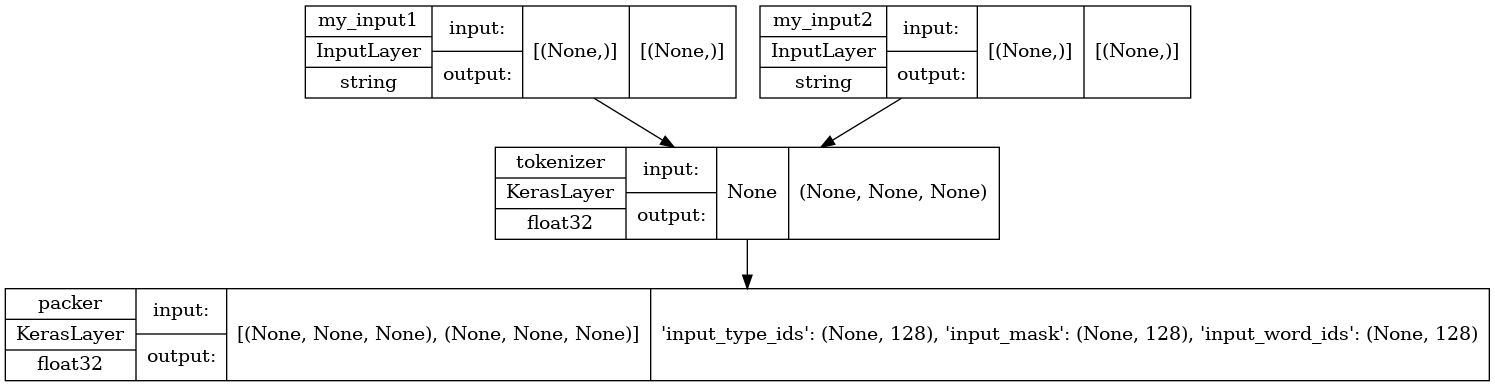

In [13]:
tf.keras.utils.plot_model(test_preprocess_model, show_shapes=True, show_dtype=True)

To apply the preprocessing in all the inputs from the dataset, you will use the `map` function from the dataset. The result is then cached for [performance](https://www.tensorflow.org/guide/data_performance#top_of_page).

In [14]:
AUTOTUNE = tf.data.AUTOTUNE


def load_dataset_from_tfds(in_memory_ds, info, split, batch_size,
                           bert_preprocess_model):
  is_training = split.startswith('train')
  dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[split])
  num_examples = info.splits[split].num_examples

  if is_training:
    dataset = dataset.shuffle(num_examples)
    dataset = dataset.repeat()
  dataset = dataset.batch(batch_size)
  dataset = dataset.map(lambda ex: (bert_preprocess_model(ex), ex['label']))
  dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
  return dataset, num_examples

## Define your model

You are now ready to define your model for sentence or sentence pair classification by feeding the preprocessed inputs through the BERT encoder and putting a linear classifier on top (or other arrangement of layers as you prefer), and using dropout for regularization.

In [15]:
def build_classifier_model(num_classes):

  class Classifier(tf.keras.Model):
    def __init__(self, num_classes):
      super(Classifier, self).__init__(name="prediction")
      self.encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True)
      self.dropout = tf.keras.layers.Dropout(0.1)
      self.dense = tf.keras.layers.Dense(num_classes)

    def call(self, preprocessed_text):
      encoder_outputs = self.encoder(preprocessed_text)
      pooled_output = encoder_outputs["pooled_output"]
      x = self.dropout(pooled_output)
      x = self.dense(x)
      return x

  model = Classifier(num_classes)
  return model

Let's try running the model on some preprocessed inputs.

In [16]:
test_classifier_model = build_classifier_model(2)
bert_raw_result = test_classifier_model(text_preprocessed)
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.65279955 0.30029675]], shape=(1, 2), dtype=float32)


## Choose a task from GLUE

You are going to use a TensorFlow DataSet from the [GLUE](https://www.tensorflow.org/datasets/catalog/glue) benchmark suite.

Colab lets you download these small datasets to the local filesystem, and the code below reads them entirely into memory, because the separate TPU worker host cannot access the local filesystem of the colab runtime.

For bigger datasets, you'll need to create your own [Google Cloud Storage](https://cloud.google.com/storage) bucket and have the TPU worker read the data from there. You can learn more in the [TPU guide](https://www.tensorflow.org/guide/tpu#input_datasets).

It's recommended to start with the CoLa dataset (for single sentence) or MRPC (for multi sentence) since these are small and don't take long to fine tune.

In [17]:
tfds_name = 'glue/cola'  #@param ['glue/cola', 'glue/sst2', 'glue/mrpc', 'glue/qqp', 'glue/mnli', 'glue/qnli', 'glue/rte', 'glue/wnli']

tfds_info = tfds.builder(tfds_name).info

sentence_features = list(tfds_info.features.keys())
sentence_features.remove('idx')
sentence_features.remove('label')

available_splits = list(tfds_info.splits.keys())
train_split = 'train'
validation_split = 'validation'
test_split = 'test'
if tfds_name == 'glue/mnli':
  validation_split = 'validation_matched'
  test_split = 'test_matched'

num_classes = tfds_info.features['label'].num_classes
num_examples = tfds_info.splits.total_num_examples

print(f'Using {tfds_name} from TFDS')
print(f'This dataset has {num_examples} examples')
print(f'Number of classes: {num_classes}')
print(f'Features {sentence_features}')
print(f'Splits {available_splits}')

with tf.device('/job:localhost'):
  # batch_size=-1 is a way to load the dataset into memory
  in_memory_ds = tfds.load(tfds_name, batch_size=-1, shuffle_files=True)

# The code below is just to show some samples from the selected dataset
print(f'Here are some sample rows from {tfds_name} dataset')
sample_dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[train_split])

labels_names = tfds_info.features['label'].names
print(labels_names)
print()

sample_i = 1
for sample_row in sample_dataset.take(5):
  samples = [sample_row[feature] for feature in sentence_features]
  print(f'sample row {sample_i}')
  for sample in samples:
    print(sample.numpy())
  sample_label = sample_row['label']

  print(f'label: {sample_label} ({labels_names[sample_label]})')
  print()
  sample_i += 1

Using glue/cola from TFDS
This dataset has 10657 examples
Number of classes: 2
Features ['sentence']
Splits ['train', 'validation', 'test']
Here are some sample rows from glue/cola dataset
['unacceptable', 'acceptable']

sample row 1
b'It is this hat that it is certain that he was wearing.'
label: 1 (acceptable)

sample row 2
b'Her efficient looking up of the answer pleased the boss.'
label: 1 (acceptable)

sample row 3
b'Both the workers will wear carnations.'
label: 1 (acceptable)

sample row 4
b'John enjoyed drawing trees for his syntax homework.'
label: 1 (acceptable)

sample row 5
b'We consider Leslie rather foolish, and Lou a complete idiot.'
label: 1 (acceptable)



The dataset also determines the problem type (classification or regression) and the appropriate loss function for training.

In [18]:
def get_configuration(glue_task):

  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

  if glue_task == 'glue/cola':
    metrics = tfa.metrics.MatthewsCorrelationCoefficient(num_classes=2)
  else:
    metrics = tf.keras.metrics.SparseCategoricalAccuracy(
        'accuracy', dtype=tf.float32)

  return metrics, loss

## Train your model

Finally, you can train the model end-to-end on the dataset you chose.

### Distribution

Recall the set-up code at the top, which has connected the colab runtime to
a TPU worker with multiple TPU devices. To distribute training onto them, you will create and compile your main Keras model within the scope of the TPU distribution strategy. (For details, see [Distributed training with Keras](https://www.tensorflow.org/tutorials/distribute/keras).)

Preprocessing, on the other hand, runs on the CPU of the worker host, not the TPUs, so the Keras model for preprocessing as well as the training and validation datasets mapped with it are built outside the distribution strategy scope. The call to `Model.fit()` will take care of distributing the passed-in dataset to the model replicas.

Note: The single TPU worker host already has the resource objects (think: a lookup table) needed for tokenization. Scaling up to multiple workers requires use of `Strategy.experimental_distribute_datasets_from_function` with a function that loads the preprocessing model separately onto each worker.

### Optimizer

Fine-tuning follows the optimizer set-up from BERT pre-training (as in [Classify text with BERT](https://www.tensorflow.org/text/tutorials/classify_text_with_bert)): It uses the AdamW optimizer with a linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [19]:
epochs = 3
batch_size = 32
init_lr = 2e-5

print(f'Fine tuning {tfhub_handle_encoder} model')
bert_preprocess_model = make_bert_preprocess_model(sentence_features)

with strategy.scope():

  # metric have to be created inside the strategy scope
  metrics, loss = get_configuration(tfds_name)

  train_dataset, train_data_size = load_dataset_from_tfds(
      in_memory_ds, tfds_info, train_split, batch_size, bert_preprocess_model)
  steps_per_epoch = train_data_size // batch_size
  num_train_steps = steps_per_epoch * epochs
  num_warmup_steps = num_train_steps // 10

  validation_dataset, validation_data_size = load_dataset_from_tfds(
      in_memory_ds, tfds_info, validation_split, batch_size,
      bert_preprocess_model)
  validation_steps = validation_data_size // batch_size

  classifier_model = build_classifier_model(num_classes)

  optimizer = optimization.create_optimizer(
      init_lr=init_lr,
      num_train_steps=num_train_steps,
      num_warmup_steps=num_warmup_steps,
      optimizer_type='adamw')

  classifier_model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])

  classifier_model.fit(
      x=train_dataset,
      validation_data=validation_dataset,
      steps_per_epoch=steps_per_epoch,
      epochs=epochs,
      validation_steps=validation_steps)

Fine tuning https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3 model


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['idx', 'label'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


Epoch 1/3


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("AdamWeightDecay/gradients/StatefulPartitionedCall:1", shape=(None,), dtype=int32), values=Tensor("clip_by_global_norm/clip_by_global_norm/_0:0", dtype=float32), dense_shape=Tensor("AdamWeightDecay/gradients/StatefulPartitionedCall:2", shape=(None,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


267/267 [==============================] - 76s 78ms/step - loss: 0.5383 - MatthewsCorrelationCoefficient: 0.0000e+00 - val_loss: 0.4666 - val_MatthewsCorrelationCoefficient: 0.0000e+00
Epoch 2/3
267/267 [==============================] - 15s 56ms/step - loss: 0.3595 - MatthewsCorrelationCoefficient: 0.0000e+00 - val_loss: 0.5112 - val_MatthewsCorrelationCoefficient: 0.0000e+00
Epoch 3/3
267/267 [==============================] - 15s 56ms/step - loss: 0.2482 - MatthewsCorrelationCoefficient: 0.0000e+00 - val_loss: 0.6271 - val_MatthewsCorrelationCoefficient: 0.0000e+00


## Export for inference

You will create a final model that has the preprocessing part and the fine-tuned BERT we've just created.

At inference time, preprocessing needs to be part of the model (because there is no longer a separate input queue as for training data that does it). Preprocessing is not just computation; it has its own resources (the vocab table) that must be attached to the Keras Model that is saved for export.
This final assembly is what will be saved.

You are going to save the model on colab and later you can download to keep it for the future (**View -> Table of contents -> Files**).


In [20]:
main_save_path = './my_models'
bert_type = tfhub_handle_encoder.split('/')[-2]
saved_model_name = f'{tfds_name.replace("/", "_")}_{bert_type}'

saved_model_path = os.path.join(main_save_path, saved_model_name)

preprocess_inputs = bert_preprocess_model.inputs
bert_encoder_inputs = bert_preprocess_model(preprocess_inputs)
bert_outputs = classifier_model(bert_encoder_inputs)
model_for_export = tf.keras.Model(preprocess_inputs, bert_outputs)

print('Saving', saved_model_path)

# Save everything on the Colab host (even the variables from TPU memory)
save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
model_for_export.save(saved_model_path, include_optimizer=False,
                      options=save_options)

Saving ./my_models/glue_cola_bert_en_uncased_L-12_H-768_A-12


2022-12-15 12:14:54.576109: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


## Test the model

The final step is testing the results of your exported model.

Just to make some comparison, let's reload the model and test it using some inputs from the test split from the dataset.

Note: The test is done on the colab host, not the TPU worker that it has connected to, so it appears below with explicit device placements. You can omit those when loading the SavedModel elsewhere.

In [21]:
with tf.device('/job:localhost'):
  reloaded_model = tf.saved_model.load(saved_model_path)

In [22]:
#@title Utility methods

def prepare(record):
  model_inputs = [[record[ft]] for ft in sentence_features]
  return model_inputs


def prepare_serving(record):
  model_inputs = {ft: record[ft] for ft in sentence_features}
  return model_inputs


def print_bert_results(test, bert_result, dataset_name):

  bert_result_class = tf.argmax(bert_result, axis=1)[0]

  if dataset_name == 'glue/cola':
    print('sentence:', test[0].numpy())
    if bert_result_class == 1:
      print('This sentence is acceptable')
    else:
      print('This sentence is unacceptable')

  elif dataset_name == 'glue/sst2':
    print('sentence:', test[0])
    if bert_result_class == 1:
      print('This sentence has POSITIVE sentiment')
    else:
      print('This sentence has NEGATIVE sentiment')

  elif dataset_name == 'glue/mrpc':
    print('sentence1:', test[0])
    print('sentence2:', test[1])
    if bert_result_class == 1:
      print('Are a paraphrase')
    else:
      print('Are NOT a paraphrase')

  elif dataset_name == 'glue/qqp':
    print('question1:', test[0])
    print('question2:', test[1])
    if bert_result_class == 1:
      print('Questions are similar')
    else:
      print('Questions are NOT similar')

  elif dataset_name == 'glue/mnli':
    print('premise   :', test[0])
    print('hypothesis:', test[1])
    if bert_result_class == 1:
      print('This premise is NEUTRAL to the hypothesis')
    elif bert_result_class == 2:
      print('This premise CONTRADICTS the hypothesis')
    else:
      print('This premise ENTAILS the hypothesis')

  elif dataset_name == 'glue/qnli':
    print('question:', test[0])
    print('sentence:', test[1])
    if bert_result_class == 1:
      print('The question is NOT answerable by the sentence')
    else:
      print('The question is answerable by the sentence')

  elif dataset_name == 'glue/rte':
    print('sentence1:', test[0])
    print('sentence2:', test[1])
    if bert_result_class == 1:
      print('Sentence1 DOES NOT entails sentence2')
    else:
      print('Sentence1 entails sentence2')

  elif dataset_name == 'glue/wnli':
    print('sentence1:', test[0])
    print('sentence2:', test[1])
    if bert_result_class == 1:
      print('Sentence1 DOES NOT entails sentence2')
    else:
      print('Sentence1 entails sentence2')

  print('BERT raw results:', bert_result[0])
  print()

### Test

In [23]:
with tf.device('/job:localhost'):
  test_dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[test_split])
  for test_row in test_dataset.shuffle(1000).map(prepare).take(5):
    if len(sentence_features) == 1:
      result = reloaded_model(test_row[0])
    else:
      result = reloaded_model(list(test_row))

    print_bert_results(test_row, result, tfds_name)

sentence: [b'Susan thinks that nobody likes her.']
This sentence is acceptable
BERT raw results: tf.Tensor([-1.8933294  3.5275488], shape=(2,), dtype=float32)

sentence: [b'Once Janet left, Fred became a lot crazier.']
This sentence is acceptable
BERT raw results: tf.Tensor([-1.7920495  2.6326442], shape=(2,), dtype=float32)

sentence: [b'What we donated a chopper to was the new hospital']
This sentence is unacceptable
BERT raw results: tf.Tensor([ 1.3995948  -0.19624823], shape=(2,), dtype=float32)

sentence: [b'I was told that by a little bird.']
This sentence is acceptable
BERT raw results: tf.Tensor([-1.386563  3.435152], shape=(2,), dtype=float32)

sentence: [b'For to do that would be a mistake.']
This sentence is unacceptable
BERT raw results: tf.Tensor([ 2.3502376 -1.3375548], shape=(2,), dtype=float32)



If you want to use your model on [TF Serving](https://www.tensorflow.org/tfx/guide/serving), remember that it will call your SavedModel through one of its named signatures. Notice there are some small differences in the input. In Python, you can test them as follows:

In [24]:
with tf.device('/job:localhost'):
  serving_model = reloaded_model.signatures['serving_default']
  for test_row in test_dataset.shuffle(1000).map(prepare_serving).take(5):
    result = serving_model(**test_row)
    # The 'prediction' key is the classifier's defined model name.
    print_bert_results(list(test_row.values()), result['prediction'], tfds_name)

sentence: b'They said that they would all work on that, and all work on that they did.'
This sentence is unacceptable
BERT raw results: tf.Tensor([ 0.71320724 -0.01210704], shape=(2,), dtype=float32)

sentence: b'All of his conversation was reported to me.'
This sentence is acceptable
BERT raw results: tf.Tensor([-1.7974513  2.5984342], shape=(2,), dtype=float32)

sentence: b'Mickey looked it up.'
This sentence is acceptable
BERT raw results: tf.Tensor([-2.4198797  3.6533701], shape=(2,), dtype=float32)

sentence: b'A unicorn is in the garden.'
This sentence is acceptable
BERT raw results: tf.Tensor([-2.2405655  3.7187355], shape=(2,), dtype=float32)

sentence: b'Chris handed Bo a ticket.'
This sentence is acceptable
BERT raw results: tf.Tensor([-2.416213  3.539216], shape=(2,), dtype=float32)



You did it! Your saved model could be used for serving or simple inference in a process, with a simpler api with less code and easier to maintain.

## Next Steps

Now that you've tried one of the base BERT models, you can try other ones to achieve more accuracy or maybe with smaller model versions.

You can also try in other datasets.